## Find local maxima / Clusters

In [44]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

In [45]:
import healpy as hp
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from sklearn.neighbors import KernelDensity

### Part I: Kernel Density Estimation of the overdensity field

In [46]:
# Import the coordinates of the LSBGs objects
ra_DES, dec_DES = np.loadtxt("DES_polygon.dat", usecols=(0,1), unpack=3)
ra, dec= np.loadtxt("LSBGs_properties.dat", usecols=(1,2), unpack=3)
for i in range(len(ra)):
    if (ra[i] > 150.):
        ra[i] = ra[i]-360.
        
latlon = np.vstack([dec,ra]).T

In [47]:
# Import the Healpix footprint
MAP = hp.read_map('y3a2_footprint_grizY_any.fits')

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


Set a coordinate grid... Define the coordinate limits

In [48]:
x_min = -70.; x_max = 110.
y_min = - 70; y_max = 10.
# ============================
# Define the aspect ratio
asp_rat = (x_max-x_min)/(y_max - y_min)
base_points = 400
y_points = base_points
x_points = int(asp_rat*base_points)

In [49]:
# Create a grid of positions over which we are going to calculate the KDE
x_grid = np.linspace(x_min,x_max,x_points)
y_grid = np.linspace(y_min,y_max,y_points)

X, Y = np.meshgrid(x_grid,y_grid)
xy = np.vstack([Y.ravel(),X.ravel()]).T

Now keep only those points that are within the DES footprint

In [50]:
# Get a mask - 1 inside the DES mask
DES_mask = np.zeros(len(MAP))
DES_mask[MAP>0] = 1 

In [51]:
# Get the healpix indices xy points
HP_ind = hp.ang2pix(4096, xy[:,1], xy[:,0], lonlat=True)
xy = np.radians(xy)

In [52]:
# Keep only those with randoms for which the value of the des mask 
# ===============================================
# ===============================================
# Keep local mask
LOCAL_mask = DES_mask[HP_ind]

ra_loc = xy[:,1]
dec_loc = xy[:,0]

# Keep those with LOCAL_mask = 1
ra_pos = ra_loc[LOCAL_mask==1]
dec_pos = dec_loc[LOCAL_mask==1]

#land_mask = np.vstack()
land_mask = xy[LOCAL_mask==1]

- Now it is time to.....

#### Fit our KDE 

For that I have to pick a kernel size... From previous exploration I have seen that cluster profiles decay and approach average at a level of ~ 1 deg. So, I think that, making an analogy with a histogram, a "bin" (kernel) size of 0.1 degrees is a good smoothing size.

In [53]:
# Kernel size in degrees
kern_size = 0.1
# Transform it to radians
kern_size = np.radians(kern_size)
kern_size = 0.005
# Fit now 
kde = KernelDensity(bandwidth=kern_size, kernel='gaussian', metric='haversine')
kde.fit(np.radians(latlon))

KernelDensity(algorithm='auto', atol=0, bandwidth=0.005, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='haversine',
       metric_params=None, rtol=0)

In [54]:
# Evaluate on the xy map 
Z = np.exp(kde.score_samples(xy))
Z[LOCAL_mask==0] = 0
Z = Z.reshape(X.shape)

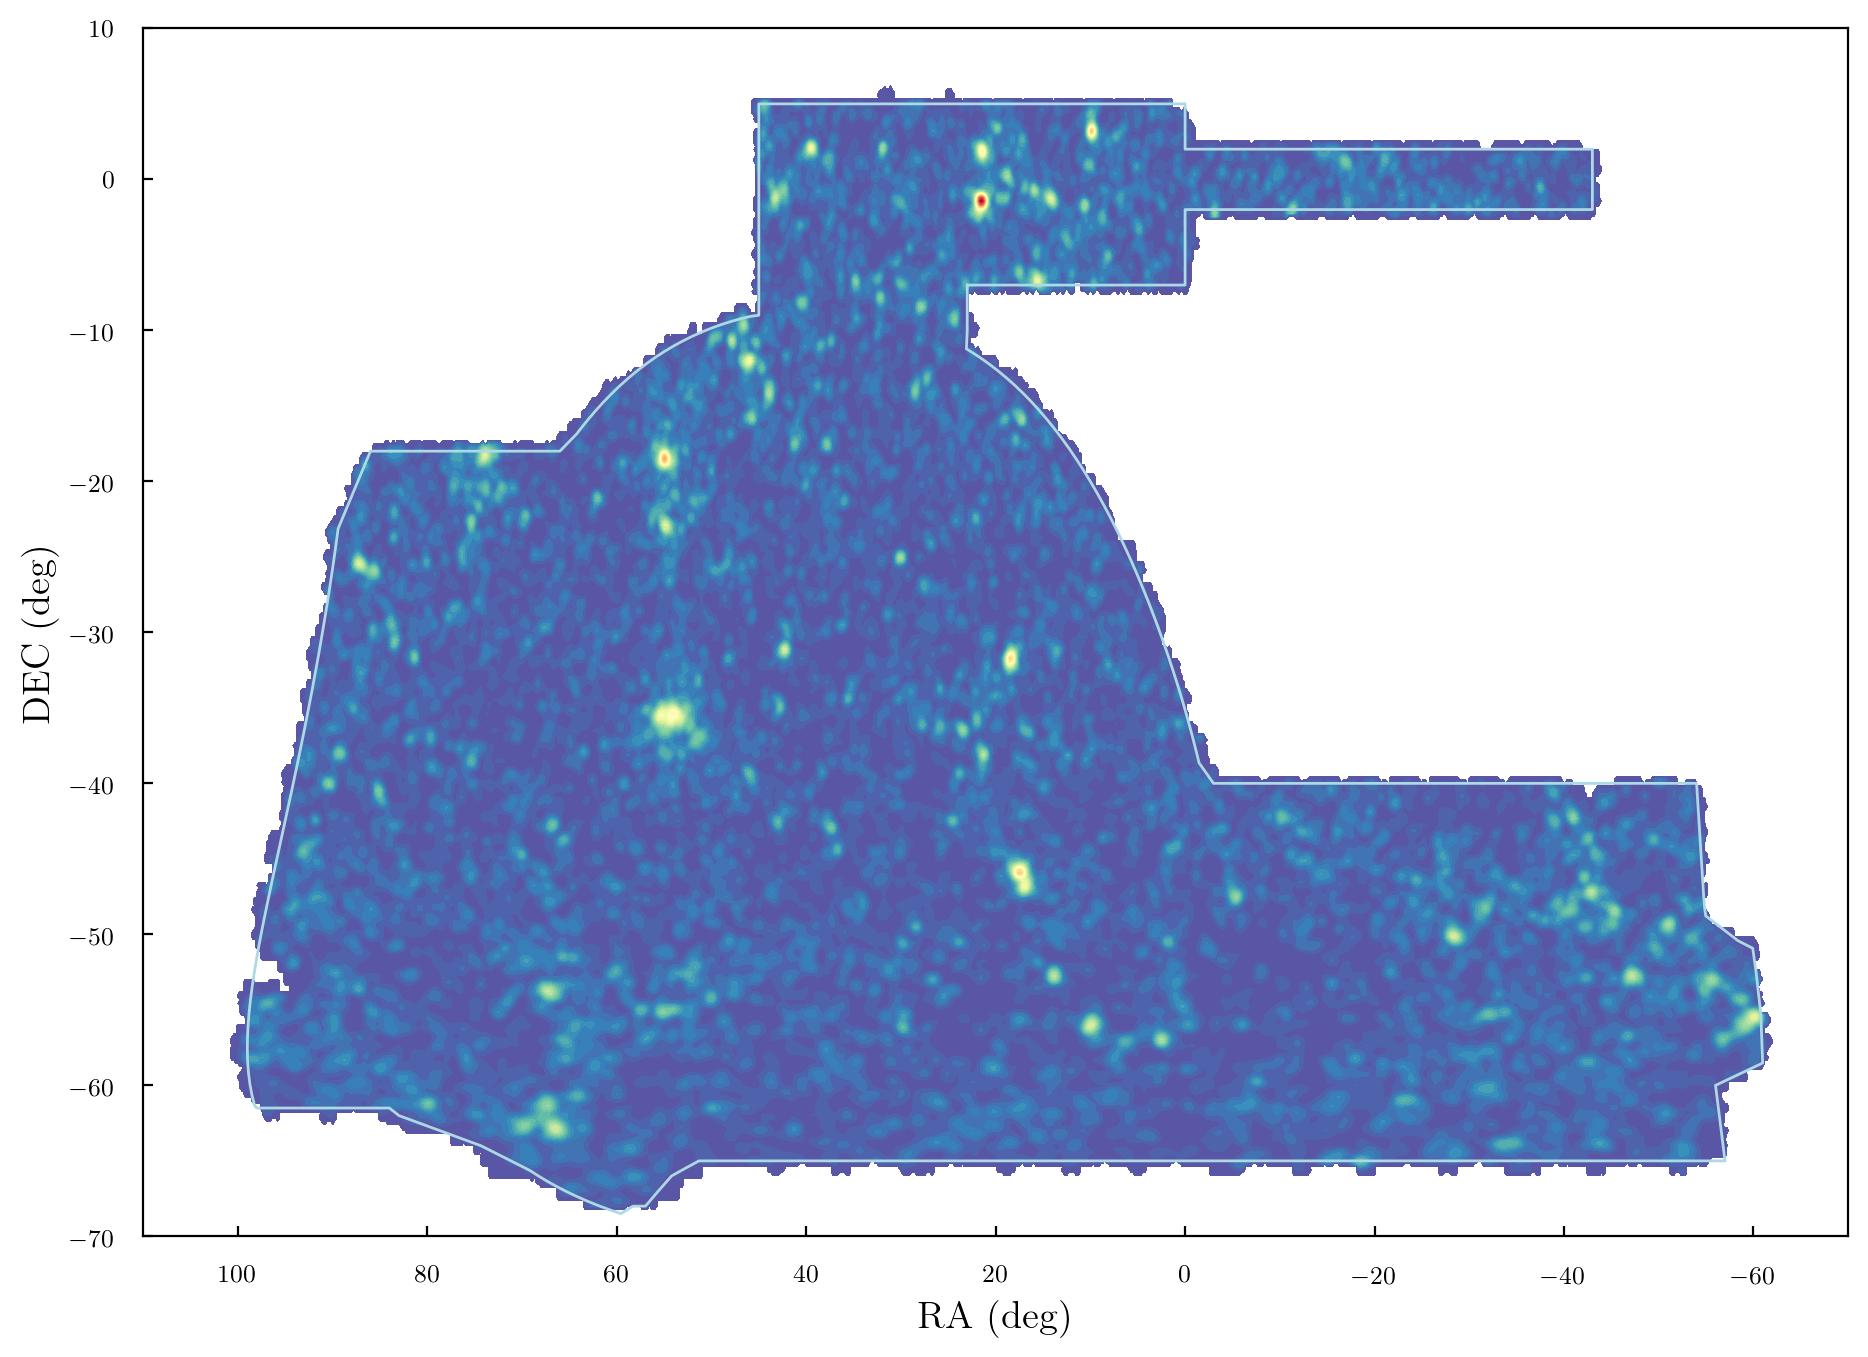

In [60]:
plt.figure(figsize = (11.0,8.0))

levels = np.linspace(1e-6, Z.max(),40)

plt.plot(ra_DES, dec_DES, c='lightblue', linewidth=1.0)
plt.contourf(X,Y,Z, levels=levels, cmap='Spectral_r')

plt.xlim(110,-70);plt.ylim(-70,10)
plt.xlabel('RA (deg)',fontsize=14);plt.ylabel('DEC (deg)', fontsize=14)
plt.show()

#### - Now repeat the KDE fitting but with random, mock data

For that reason create a number of random points, equal to the LSB real points, and recalculate the KDE. Find mean and std deviation of that sample

In [62]:
N_LSB = len(ra)
# ===========================
# ===========================
conv = np.pi/180.
ra_min = -70.0*conv
ra_max = 110.*conv
dec_min = -70.*conv
dec_max = 10.*conv
# ==========================================================================
# ==========================================================================
# Empty arrays
ra_rand = []
dec_rand = []

# Start from j = 0 
j = 0
while (j<N_LSB):
    
    rand_ra = np.random.uniform(ra_min, ra_max)
    rand_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max))
    rand_dec = np.arcsin(rand_sindec)
    
    rand_ra = rand_ra/conv
    rand_dec = rand_dec/conv
    
    # Find if the proposed point is within the footprint
    
    HP_ind = hp.ang2pix(4096, rand_ra, rand_dec, lonlat=True)
    
    if (DES_mask[HP_ind]==1):
        
        ra_rand.append(rand_ra)
        dec_rand.append(rand_dec)
        
        j += 1
    
    
    
print(len(ra_rand))

20576


In [63]:
latlon_rand = np.vstack([dec_rand,ra_rand]).T
kde_rand = KernelDensity(bandwidth=0.005, kernel='gaussian', metric='haversine')
kde_rand.fit(np.radians(latlon_rand))

KernelDensity(algorithm='auto', atol=0, bandwidth=0.005, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='haversine',
       metric_params=None, rtol=0)

In [64]:
#Z = np.zeros([np.shape(X)[0],np.shape(X)[1]])
Z_rand = np.exp(kde_rand.score_samples(xy))
Z_rand[LOCAL_mask==0] = 0
Z_rand = Z_rand.reshape(X.shape)

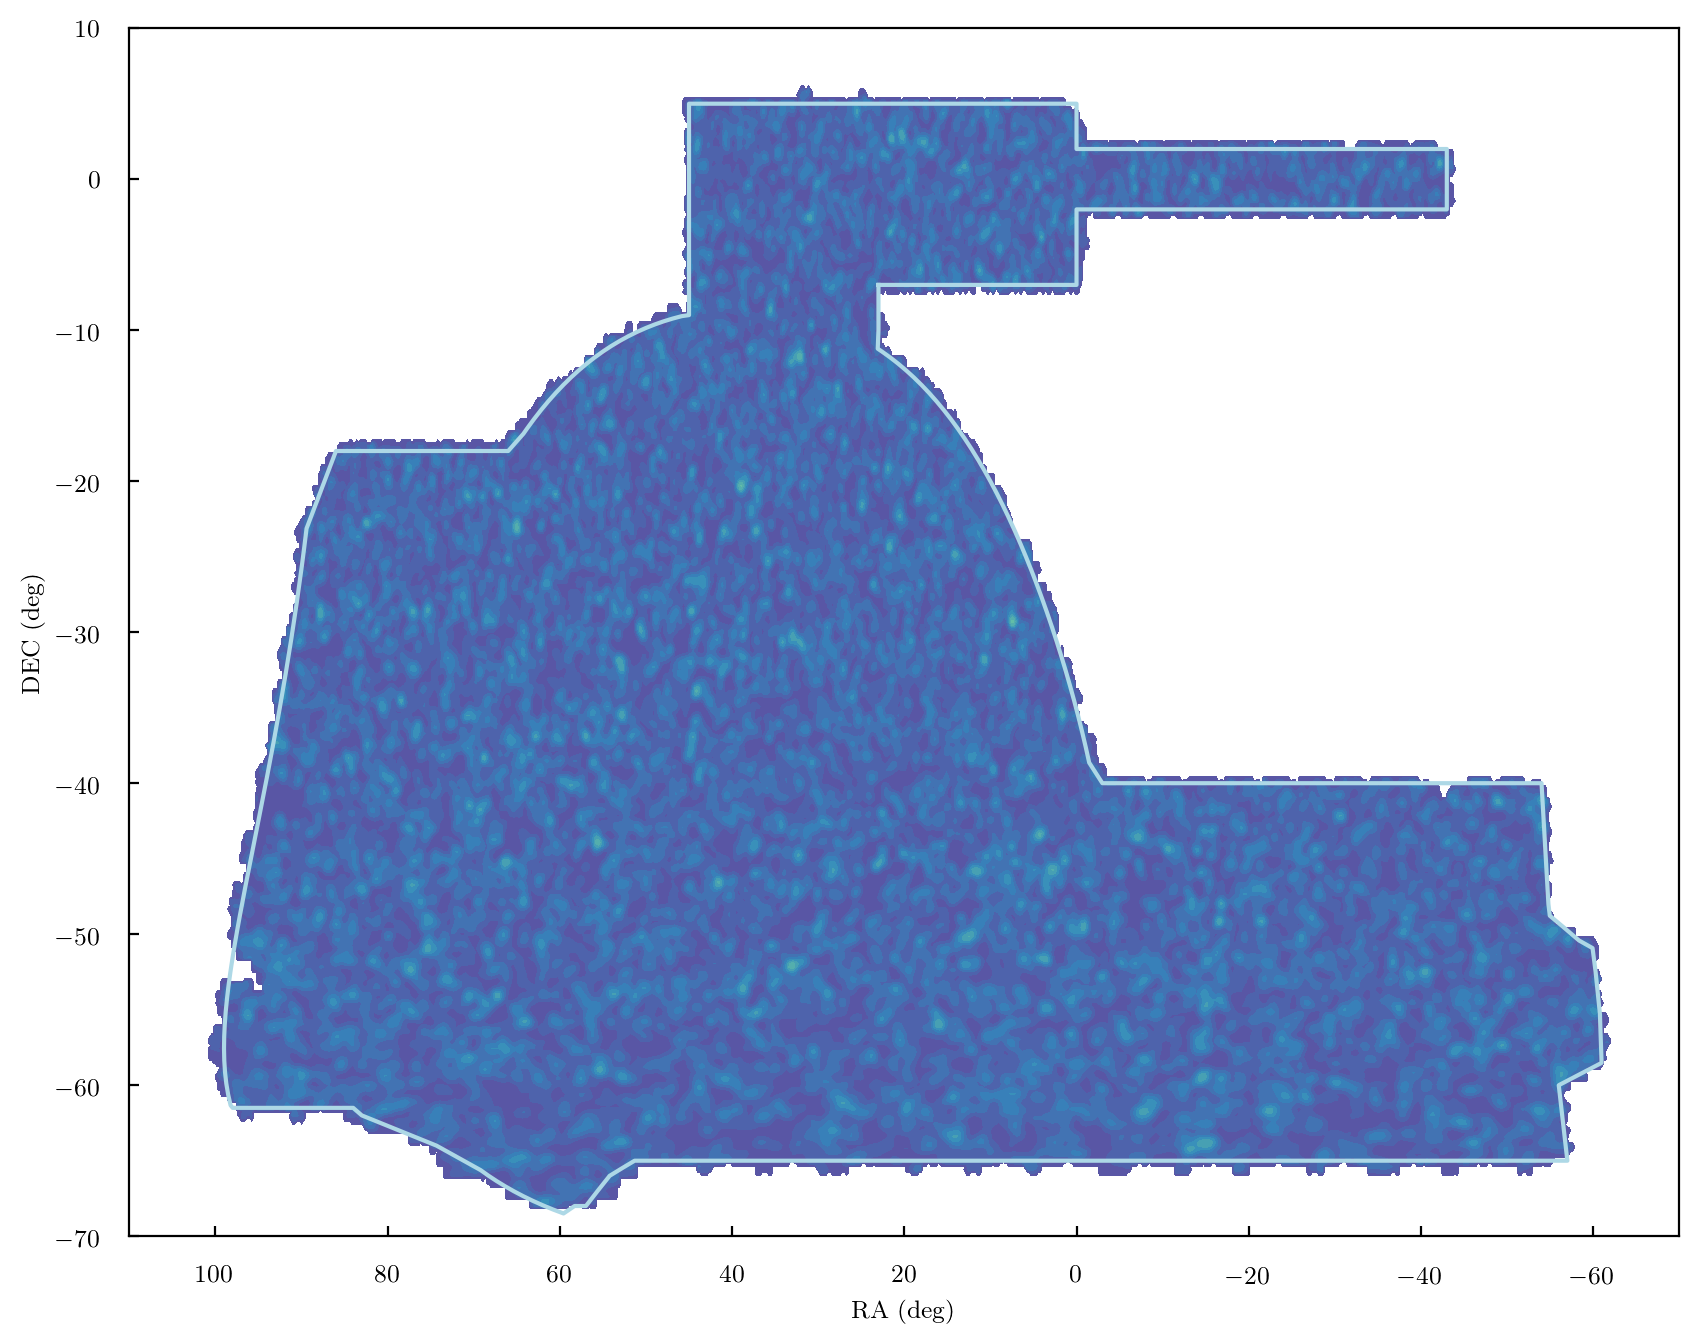

In [75]:
plt.figure(figsize = (10.0,8.0))

levels = np.linspace(1e-7, Z.max(),40)
plt.plot(ra_DES, dec_DES, c='lightblue')
plt.contourf(X,Y,Z_rand, levels=levels, cmap='Spectral_r')

plt.xlim(110,-70);plt.ylim(-70,10)
plt.xlabel('RA (deg)');plt.ylabel('DEC (deg)')
plt.show()

In [66]:
print(np.mean(Z_rand[Z_rand>0]))
mean_rand = np.mean(Z_rand[Z_rand>0])

0.6173972915906258


In [67]:
print(np.std(Z_rand[Z_rand>0]))
std_rand = np.std(Z_rand[Z_rand>0])

0.31365097827560434


In [70]:
print(mean_rand+3.0*std_rand)
print(mean_rand+5.0*std_rand)

1.558350226417439
2.1856521829686475


In [69]:
Z_rand_rav = Z_rand.ravel()
#print(np.shape(Z_rand_rav))
Z_rav = Z.ravel()

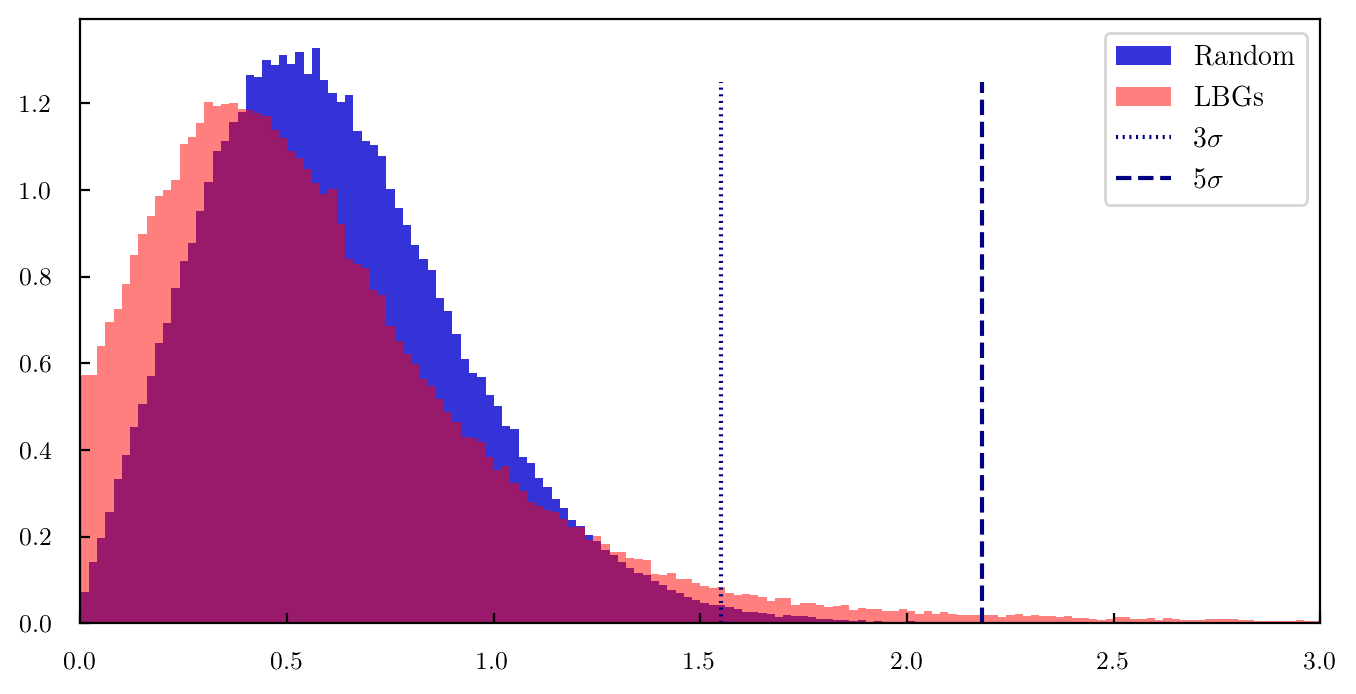

In [136]:
plt.figure(figsize = (8.0,4.0))

plt.hist(Z_rand_rav[Z_rand_rav>0],range=[0,4], bins=200, color='mediumblue', density=True, alpha=0.8, label='Random')
plt.hist(Z_rav[(Z_rav>0)], range=[0,4], bins=200, color='red', alpha=0.5,density=True, label='LBGs')

plt.vlines(1.55,0,1.25, color='navy', linestyle=':',label='3$\sigma$')
plt.vlines(2.18,0,1.25, color='navy', linestyle='--',label='5$\sigma$')
plt.xlim(0,3)
plt.legend(frameon=True, loc='upper right', fontsize=10)
plt.show()

### Find the maxima

Find the maxima in the original field that are i) 3 $\sigma$ above the random mean, ii) 5$\sigma$ above the random mean. These thresholds are $1.55$ and $2.18$.

In [202]:
from skimage.feature import peak_local_max

# First find the peaks that lie 3 sigma above the mean
xy_3sigma = peak_local_max(Z, min_distance=1,threshold_abs=1.55)
# Second find the peaks that lie 5 sigma above the mean
xy_5sigma = peak_local_max(Z, min_distance=1,threshold_abs=2.18)

# Print their sizes
print(np.shape(xy_3sigma)[0])
print(np.shape(xy_5sigma)[0])

400
158


In [203]:
# Get their ra and dec
# For the three sigma points first
ra_s_like = xy_3sigma[:,1];dec_s_like = xy_3sigma[:,0]
ra_max_3sigma = x_grid[ra_s_like];dec_max_3sigma = y_grid[dec_s_like]
# ====================================================
# ====================================================
# For the 5 sigma points now
ra_s_like = xy_5sigma[:,1];dec_s_like = xy_5sigma[:,0]
ra_max_5sigma = x_grid[ra_s_like];dec_max_5sigma = y_grid[dec_s_like]

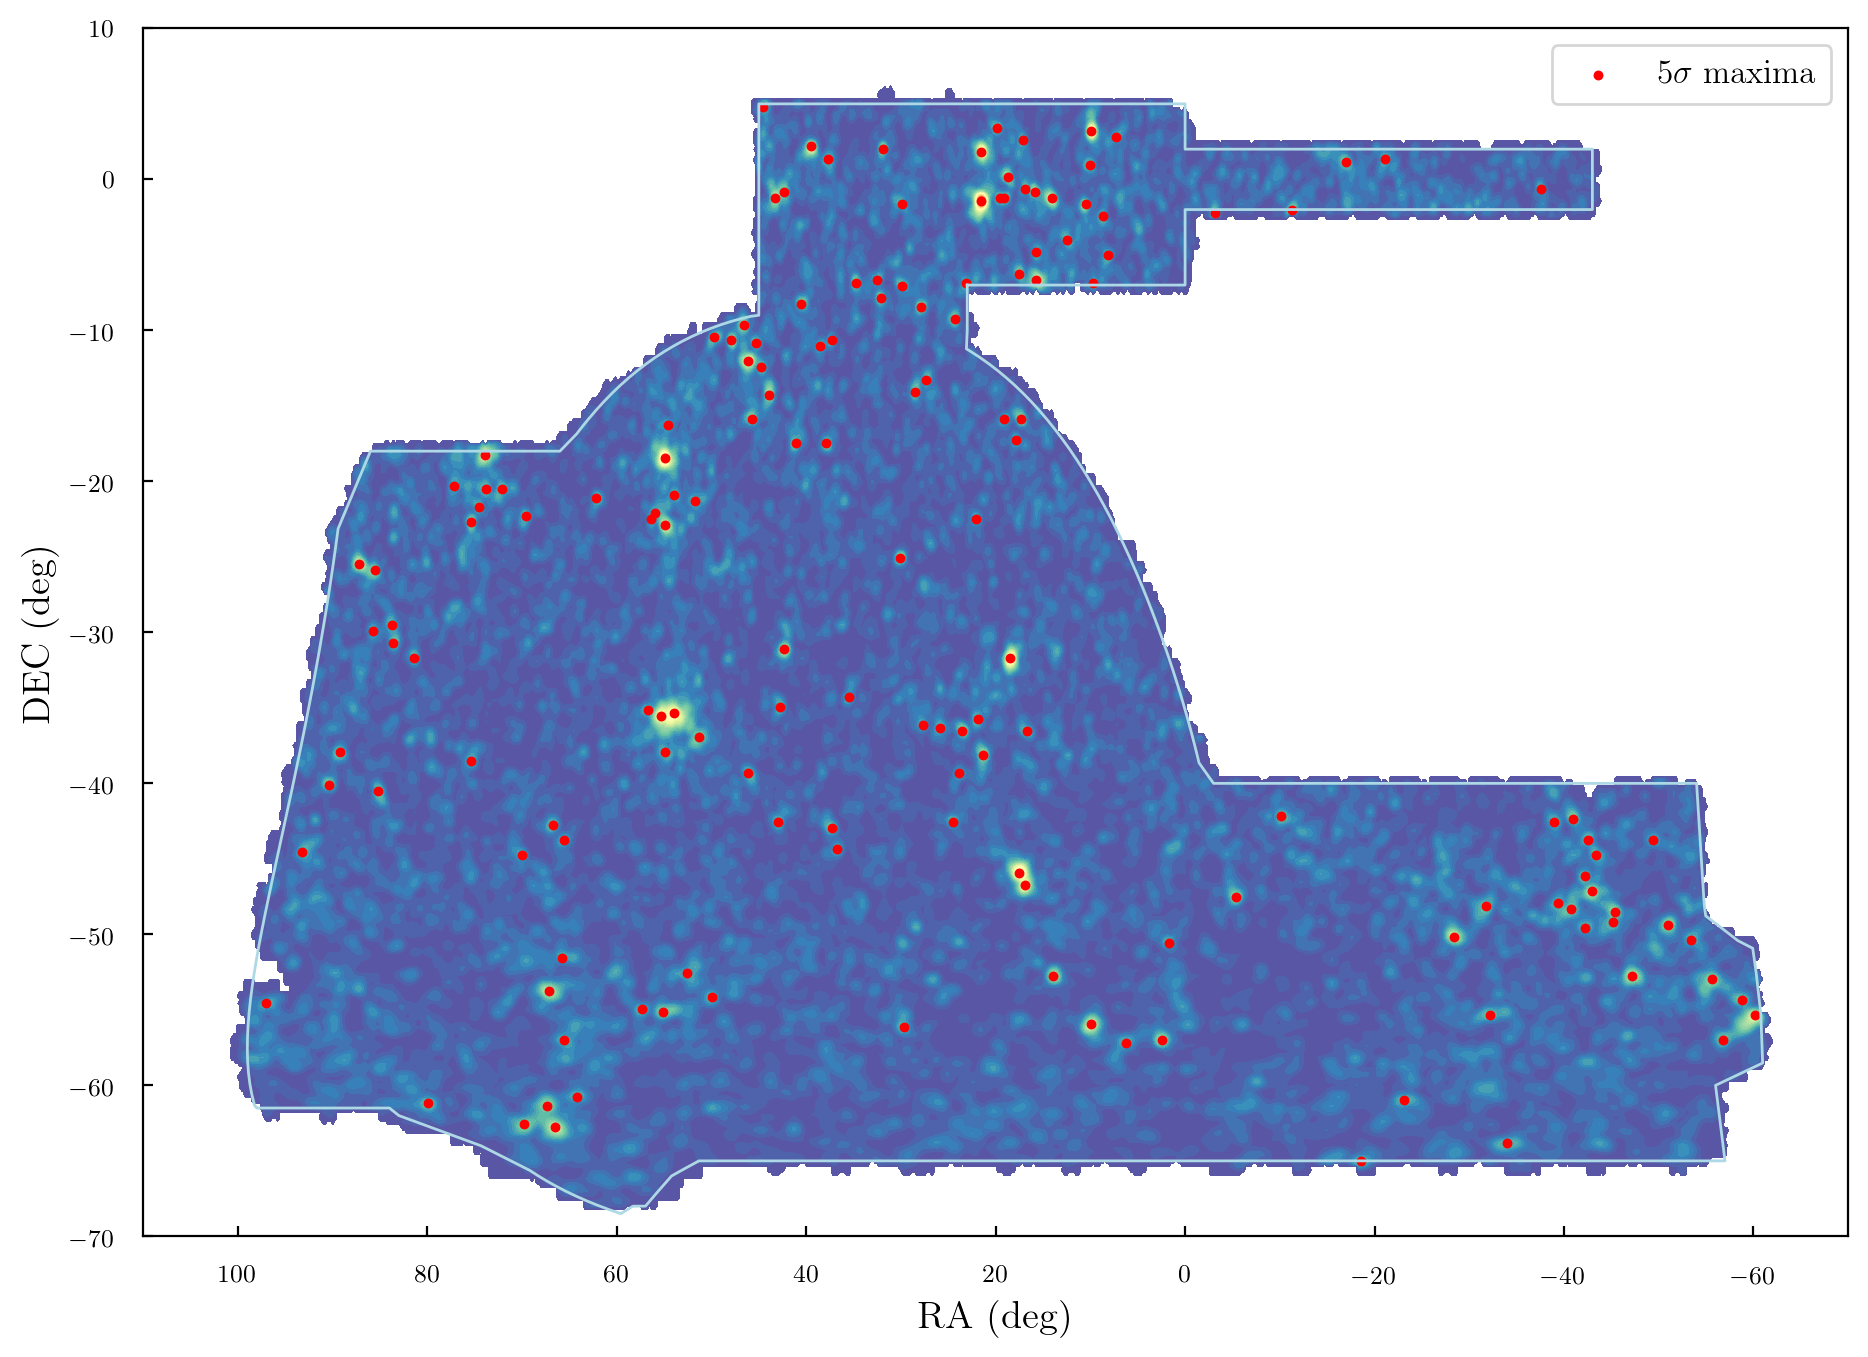

In [204]:
plt.figure(figsize = (11.0,8.0))

levels = np.linspace(1e-6, Z.max(),40)

plt.plot(ra_DES, dec_DES, c='lightblue', linewidth=1.0)
plt.contourf(X,Y,Z, levels=levels, cmap='Spectral_r')
#plt.scatter(ra_max_3sigma, dec_max_3sigma, c='firebrick', s=4.5, marker='^', label='$3\sigma$ maxima')
plt.scatter(ra_max_5sigma, dec_max_5sigma, c='r', s=6.5, label='$5\sigma$ maxima')

plt.xlim(110,-70);plt.ylim(-70,10)
plt.xlabel('RA (deg)',fontsize=14);plt.ylabel('DEC (deg)', fontsize=14)
plt.legend(loc='upper right', frameon=True, fontsize=12)
plt.show()

### Find nearby clusters and NGC galaxies

Now, find clusters all clusters in the Abell and Reflex catalogs and Galaxies in the NGC catalog.


- First, load the catalogs:

In [205]:
# Open and read the Abell catalog
Abell_cat = fits.open('Abell.fits')
# =============================================
# =============================================
# Open and read the Reflex catalog
RAh, RAm, RAs, DECd,DECm, DECs = np.loadtxt("Reflex_RADEC.dat",  unpack=3, usecols=[1,2,3,4,5,6])
# =============================================
# =============================================
# Open and read the NGC catalog
NGC_cat = fits.open('NGC_2.fit')

In [206]:
name_Abell = Abell_cat[1].data['NAME']
ra_Abell = Abell_cat[1].data['RA']
dec_Abell = Abell_cat[1].data['DEC']
z_Abell = Abell_cat[1].data['REDSHIFT']

ra_Abell = ra_Abell[z_Abell<0.2]
dec_Abell = dec_Abell[z_Abell<0.2]
name_Abell = name_Abell[z_Abell<0.2]
z_Abell = z_Abell[z_Abell<0.2]
# ================================================
# ================================================
ra_NGC = NGC_cat[1].data['_RAJ2000']
dec_NGC = NGC_cat[1].data['_DEJ2000']
type_NGC = NGC_cat[1].data['Type']
name_NGC = NGC_cat[1].data['NGC']
ra_NGC = ra_NGC[type_NGC==5]
dec_NGC = dec_NGC[type_NGC==5]
name_NGC = name_NGC[type_NGC==5]
# ================================================
# ================================================
for i in range(len(ra_Abell)):
    if (ra_Abell[i] > 180.):
        ra_Abell[i] = ra_Abell[i]-360.
        
for i in range(len(ra_NGC)):
    if (ra_NGC[i] > 180.):
        ra_NGC[i] = ra_NGC[i]-360.

In [207]:
# Convert the coordinates of the clusters in the Reflex catalog from hours mins etc to degrees
ra_Reflex = RAh*15.0 + RAm/4.0 + RAs/240.0  # Right ascension in degrees
sig = np.sign(DECd)
sig[32]=sig[104]=sig[245]=sig[288]=sig[436]=1
sig[174]=sig[175]=sig[272]=sig[289]=-1
dec_Reflex = sig*(abs(DECd) + DECm/60.0 + DECs/3600.0)

for i in range(len(ra_reflex)):
    if (ra_Reflex[i] > 180.):
        ra_Reflex[i] = ra_Reflex[i]-360.

Find all objects within a given (angular) distance (in degrees).

In [208]:
# Create an object for the positions of maxima and one for the positions of the Abell clusters, Reflex clusters and
# NGC galaxies
C_Maxima = SkyCoord(ra=ra_max_3sigma*u.degree, dec=dec_max_3sigma*u.degree, frame='icrs')
C_Abell = SkyCoord(ra=ra_Abell*u.degree, dec=dec_Abell*u.degree, frame='icrs')
C_Reflex = SkyCoord(ra=ra_Reflex*u.degree, dec=dec_Reflex*u.degree, frame='icrs')
C_NGC = SkyCoord(ra=ra_NGC*u.degree, dec=dec_NGC*u.degree, frame='icrs')

In [209]:
n = len(ra_max_3sigma)
max_sep = 0.8 # Maximum allowed angular separation (in degrees)
# ==========================================================
# ==========================================================
ra_prox_Abell = []
dec_prox_Abell = []
name_prox_Abell = []
# ==========================================================
# ==========================================================
ra_prox_Reflex = []
dec_prox_Reflex = []
name_prox_Reflex = []
# ==========================================================
# ==========================================================
ra_prox_NGC = []
dec_prox_NGC = []
name_prox_NGC = []
# ==========================================================
# ==========================================================
for i in range(n):
    ra_loc = ra_max_3sigma[i]
    dec_loc = dec_max_3sigma[i]
    # Define an object for the position of the i-th maximum 
    C_loc = SkyCoord(ra=ra_loc*u.degree, dec=dec_loc*u.degree, frame='icrs')
    
    # =====================================================================================
    # =====================================================================================
    # Get the separation between this maximum and the objects in the Abell catalog
    sep_Abell = C_Abell.separation(C_loc).deg
    
    # Now keep objects that are within the separation limit
    ra_within_Abell = ra_Abell[sep_Abell<max_sep]
    dec_within_Abell = dec_Abell[sep_Abell<max_sep]
    name_within_Abell = name_Abell[sep_Abell<max_sep]
    
    
    ra_prox_Abell = np.concatenate((ra_prox_Abell, ra_within_Abell))
    dec_prox_Abell = np.concatenate((dec_prox_Abell, dec_within_Abell))
    name_prox_Abell = np.concatenate((name_prox_Abell, name_within_Abell))
    # ====================================================================================
    # ====================================================================================
    # Get the separation between this maximum and the objects in the Reflex catalog
    sep_Reflex = C_Reflex.separation(C_loc).deg
    
    # Now keep objects that are within the separation limit
    ra_within_Reflex = ra_Reflex[sep_Reflex<max_sep]
    dec_within_Reflex = dec_Reflex[sep_Reflex<max_sep]
    #name_within_Reflex = name_Reflex[sep_Reflex<max_sep]
    
    
    ra_prox_Reflex = np.concatenate((ra_prox_Reflex, ra_within_Reflex))
    dec_prox_Reflex = np.concatenate((dec_prox_Reflex, dec_within_Reflex))
    #name_prox_Reflex = np.concatenate((name_prox_Reflex, name_within_Reflex))
    # ====================================================================================
    # ====================================================================================
    # Get the separation between this maximum and the objects in the NGC catalog
    sep_NGC = C_NGC.separation(C_loc).deg
    
    # Now keep objects that are within the separation limit
    ra_within_NGC = ra_NGC[sep_NGC<max_sep]
    dec_within_NGC = dec_NGC[sep_NGC<max_sep]
    name_within_NGC = name_NGC[sep_NGC<max_sep]
    
    ra_prox_NGC = np.concatenate((ra_prox_NGC, ra_within_NGC))
    dec_prox_NGC = np.concatenate((dec_prox_NGC, dec_within_NGC))
    name_prox_NGC = np.concatenate((name_prox_NGC, name_within_NGC))

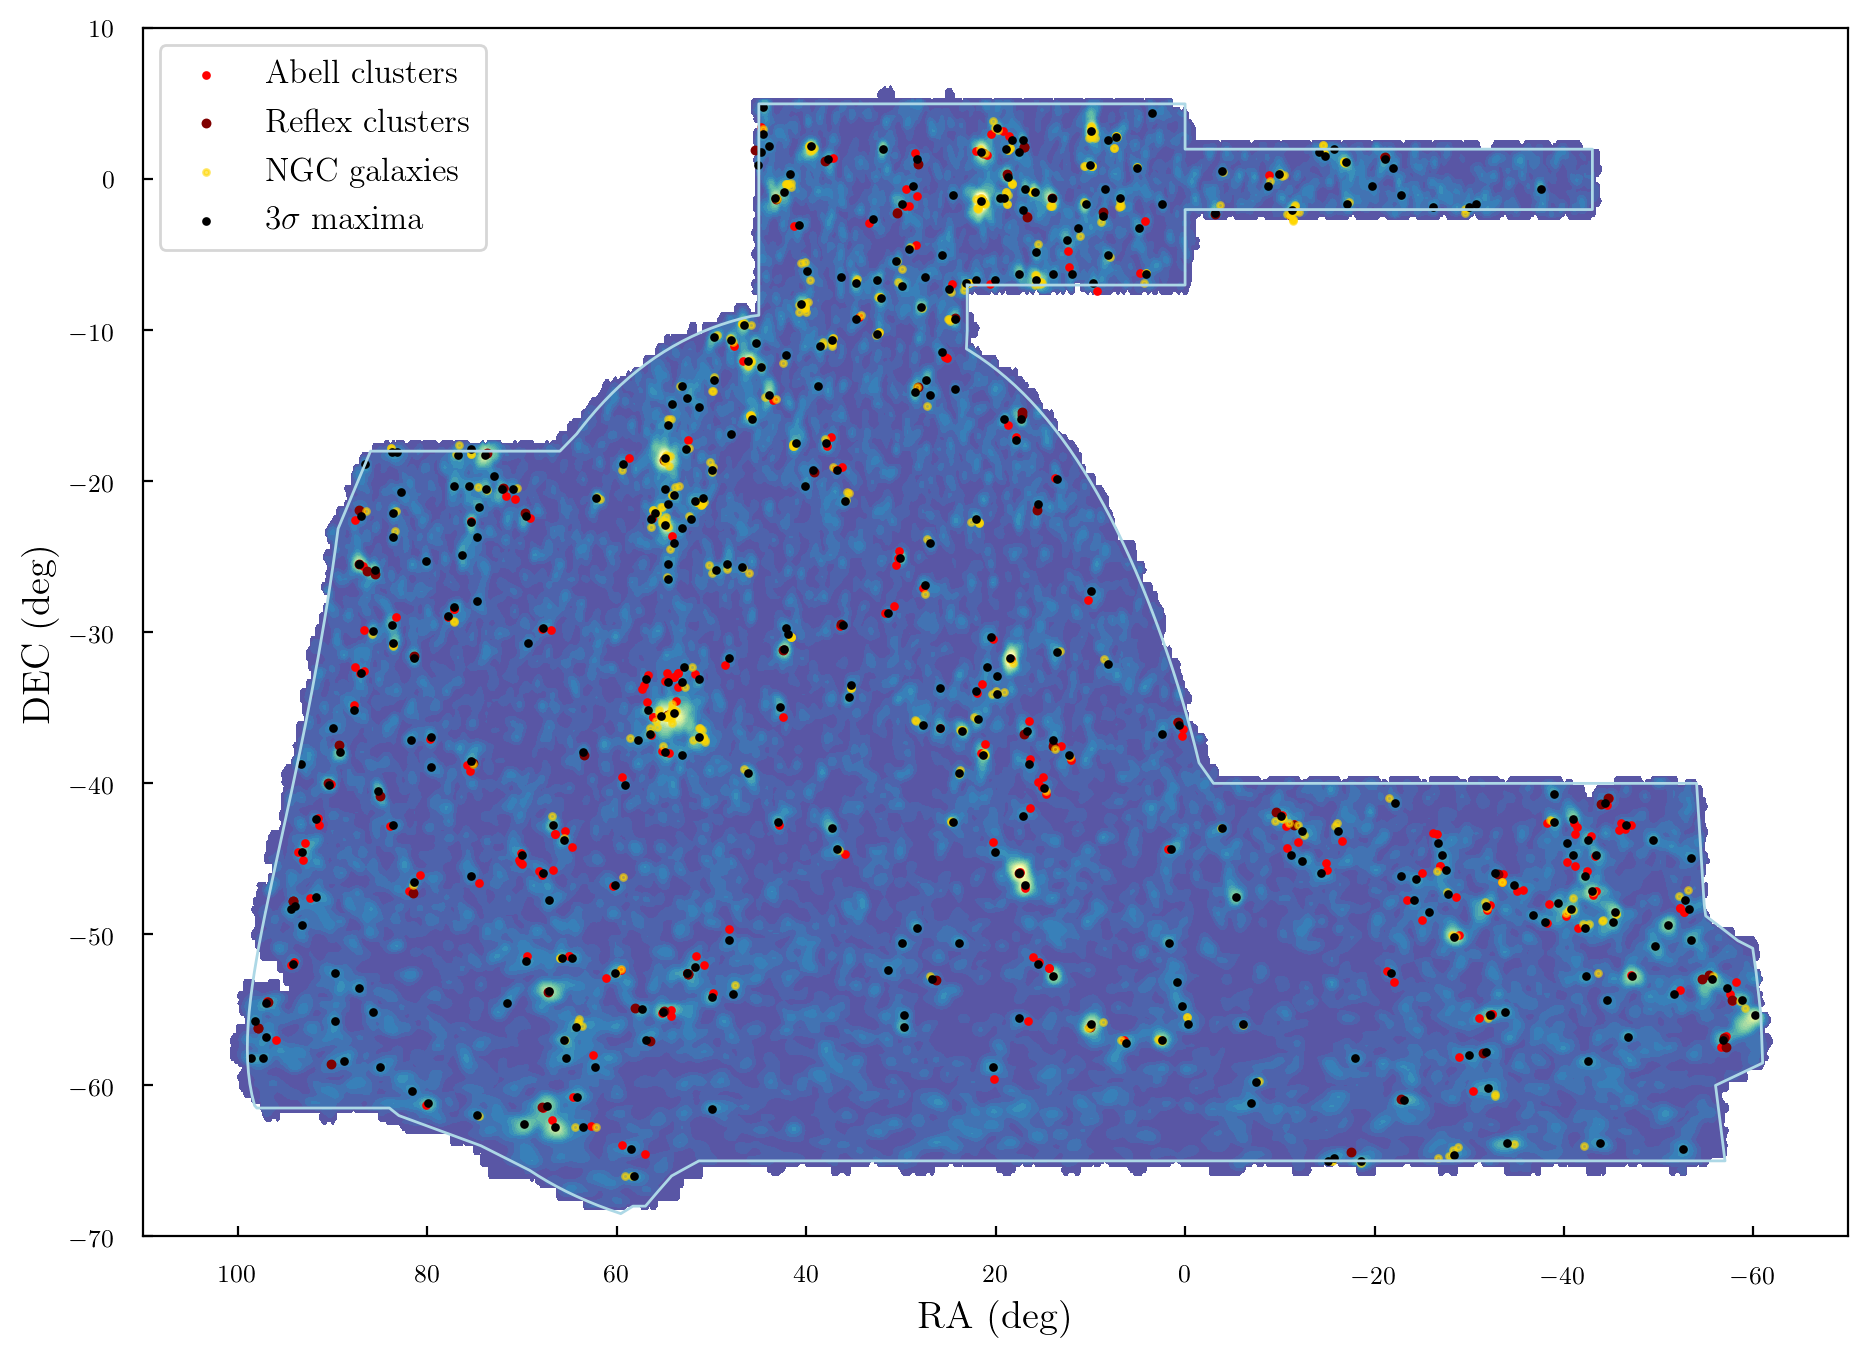

In [210]:
plt.figure(figsize = (11.0,8.0))

levels = np.linspace(1e-6, Z.max(),40)

plt.plot(ra_DES, dec_DES, c='lightblue', linewidth=1.0)
plt.contourf(X,Y,Z, levels=levels, cmap='Spectral_r')
plt.scatter(ra_prox_Abell, dec_prox_Abell, c='r', s=4.5, label='Abell clusters')
plt.scatter(ra_prox_Reflex, dec_prox_Reflex, c='maroon', s=6.5, label='Reflex clusters')
plt.scatter(ra_prox_NGC, dec_prox_NGC, c='gold', alpha=0.6, s=4.5, label='NGC galaxies')
plt.scatter(ra_max_3sigma, dec_max_3sigma, c='k', s=4.5, label='$3\sigma$ maxima')

plt.xlim(110,-70);plt.ylim(-70,10)
plt.xlabel('RA (deg)',fontsize=14);plt.ylabel('DEC (deg)', fontsize=14)
plt.legend(loc='upper left', frameon=True, fontsize=12)
plt.show()

### Calculating a $p$-value threshold

Now, instead of using a 3-$\sigma$ and 5-$\sigma$ threshold, let's re-phrase that in terms of a probability. For that reason, fit a KDE on the distribution of radnom values, and calculate a threshold for which probability is less than $p$.

In [ ]:
from scipy.stats import gaussian_kde

#Fit kernel
kernel = gaussian_kde(Z_rand_rav[Z_rand_rav>0])

In [ ]:
# Evaluate in a number of points an plot to see
kde_points_eval  = np.linspace(-1.0,4.0,100)
kde_val =  kernel(kde_points_eval)

In [ ]:
plt.figure(figsize = (4.0,2.5))

plt.plot(kde_points_eval,kde_val, c='red', label='kde')
plt.hist(Z_rand_rav[Z_rand_rav>0],range=[0,4], bins=200, color='mediumblue', density=True, alpha=0.8, label='points')

plt.legend(loc='upper right', frameon=True, fontsize=12)
plt.xlim(-0.1,4)
plt.show()

In [ ]:
uppers = np.linspace(1.0,3.0,1000)
probas = np.zeros(len(uppers))

for i in range(len(uppers)):
    probas[i] = kernel.integrate_box_1d(-0.3,uppers[i])

In [ ]:
plt.plot(probas,uppers)


In [ ]:
print(uppers[(probas>0.99865)&(probas<0.99866)])

In [ ]:
print(kernel.integrate_box_1d(-0.4,0.0))

In [ ]:
print(1.0-0.00135)